In [1]:
from sklearn.datasets import load_boston
import pandas as pd

In [2]:
data = load_boston()

In [3]:
y = data["target"]

In [4]:
data = pd.DataFrame(data = data["data"], columns=data["feature_names"])

In [5]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE
from sklearn.preprocessing import StandardScaler

from sklearn.svm import SVR
from sklearn.linear_model import Lasso
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import cross_val_score
import numpy as np

In [6]:
ss = StandardScaler()

In [7]:
d = data.copy()
d = ss.fit_transform(d)

# 1) Visualizar base em 2D

## 1.1) Visuzalização simples

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt

In [9]:
from sklearn.manifold import TSNE

In [10]:
man = TSNE()
e = man.fit_transform(d)

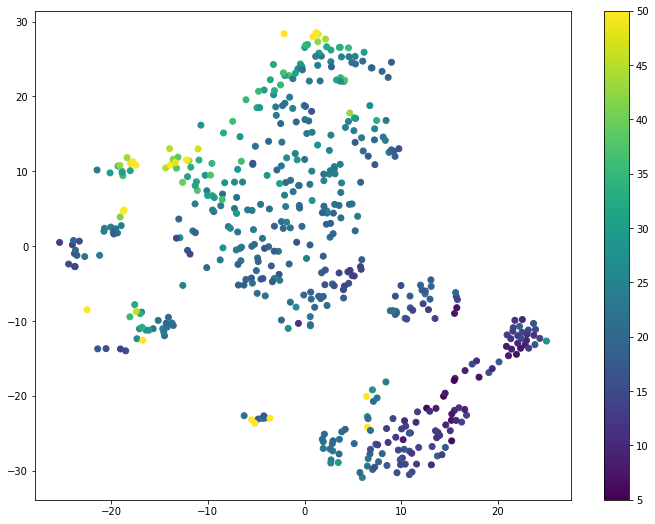

In [11]:
plt.figure(figsize=(12,9))

plt.scatter(e[:, 0], e[:, 1], c = y)
plt.colorbar()

## 1.2) Visualizar com erro

In [12]:
X_train, X_test, y_train, y_test = train_test_split(d, y, test_size = .3)
reg = SVR(kernel = "rbf")
reg.fit(X_train, y_train)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

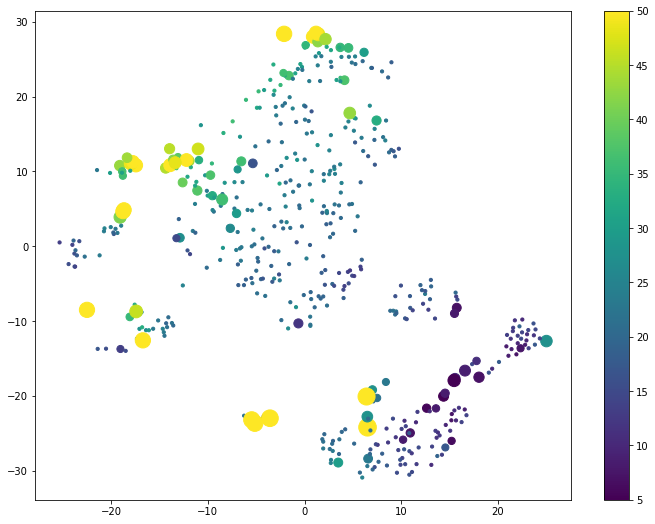

In [13]:
plt.figure(figsize=(12,9))
error = np.abs(reg.predict(d) - y)**1

eps = 5

_y = y.copy()
# _y[error<eps] = 0

_error = error.copy()
_error[error<eps] = 1

plt.scatter(e[:, 0], e[:, 1], s = _error*10, c = _y)
plt.colorbar()

# 2) Visualizar espaço geométrico da predição

## 2.1) Escolher estimador

In [14]:
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import AdaBoostRegressor
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor

In [15]:
X_train, X_test, y_train, y_test = train_test_split(e, y, test_size = .15)

In [48]:
# reg = LinearRegression()
# reg = Lasso()
reg = SVR(kernel = "rbf", epsilon=0.01, gamma = 2**-6, C = 2**2)
# reg = DecisionTreeRegressor(max_depth=5)

In [49]:
# ens = BaggingRegressor(reg,20, max_samples=.8, n_jobs=3)
ens = AdaBoostRegressor(base_estimator=reg, n_estimators=50, learning_rate=0.5)

est = reg
# est = ens
est.fit(X_train, y_train)

# est = XGBRegressor(n_estimators=500)
# est.fit(X_train, y_train, eval_set=[[X_train, y_train], [X_test, y_test]], early_stopping_rounds=20)

SVR(C=4, cache_size=200, coef0=0.0, degree=3, epsilon=0.01, gamma=0.015625,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [50]:
e1 = MSE(y_train, est.predict(X_train))
e2 = MSE(y_test, est.predict(X_test))
print("Train MSE:\t %.4f \nTest MSE:\t %.4f" % (e1,e2))

Train MSE:	 30.4383 
Test MSE:	 34.6946


## 2.2) Gerar meshgrid e plotar

In [51]:
h = .1  # step size in the mesh

x_min, x_max = e[:, 0].min() - 2, e[:, 0].max() + 2
y_min, y_max = e[:, 1].min() - 2, e[:, 1].max() + 2
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

In [52]:
Z = est.predict(np.c_[xx.ravel(), yy.ravel()])
l = len(set(Z)) # valor para calcular o melhor jeito de plotar a curva de nível
Z = Z.reshape(xx.shape)

contour done


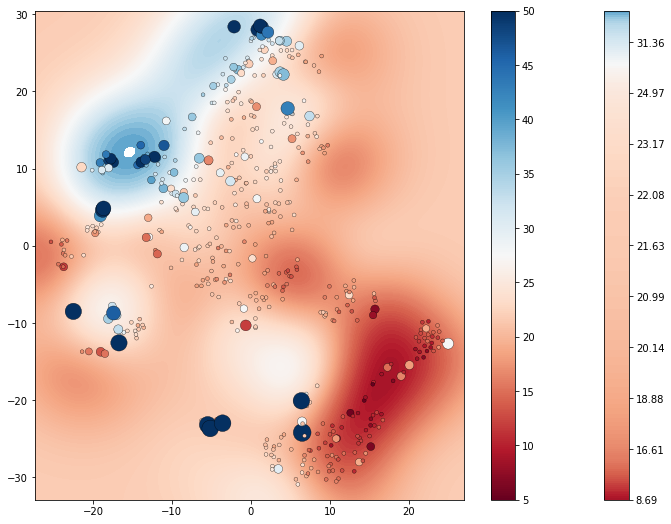

In [53]:
plt.figure(figsize=(12,9))
cm = plt.cm.RdBu
step = int(l/250)
levels = sorted(set(Z.ravel()))[::step]
plt.contourf(xx, yy, Z, cmap=cm, levels = levels, vmin = min(y), vmax = max(y))
plt.colorbar()
print("contour done")

# error = np.abs(reg.predict(e) - y)**1
error = np.abs(est.predict(e) - y)**1


eps = 5

_y = y.copy()
# _y[error<eps] = 0

_error = error.copy()
_error[error<eps] = 1.5



plt.scatter(e[:, 0], e[:, 1], lw = .3, edgecolors="black", s = _error*10, c = _y, cmap=cm)
plt.colorbar()

## 2.3) Histogramas das predições

In [22]:
mm = lambda x : [int(i) for i in ((x-min(x))/(max(x)-min(x)))*255]

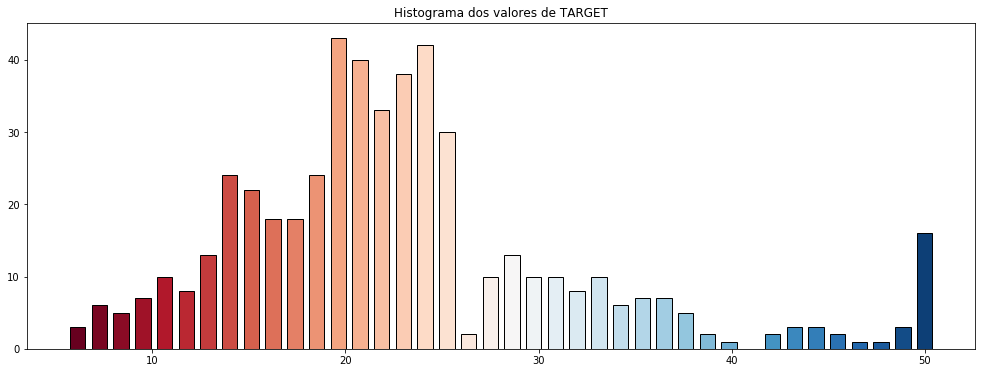

In [23]:
plt.figure(figsize=(17, 6))
h, b = np.histogram(y, bins = 40)
plt.bar(b[1:], h , color = cm(mm(b)), edgecolor = "black")
plt.title("Histograma dos valores de TARGET")

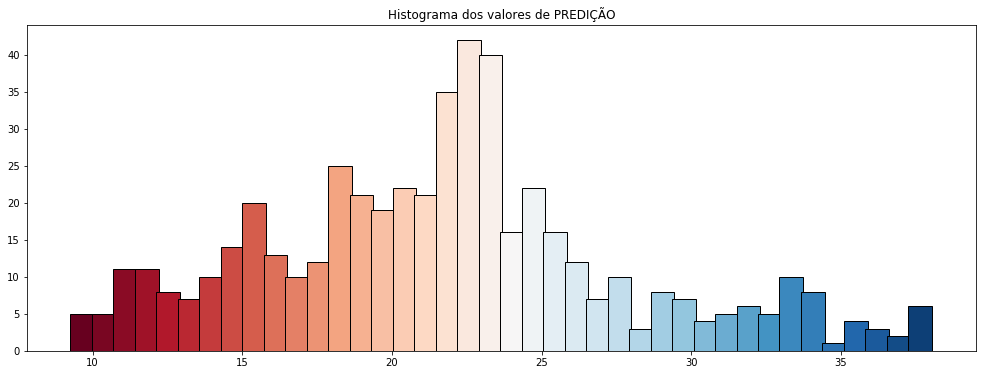

In [24]:
plt.figure(figsize=(17, 6))
pred = est.predict(e)
h, b = np.histogram(pred, bins = 40)
plt.bar(b[1:], h , color = cm(mm(b)), edgecolor = "black")
plt.title("Histograma dos valores de PREDIÇÃO")